# Tensorflow SOM with multi_conv_rnn

In [1]:
import tensorflow as tf
from tensorflow.python.tools import inspect_checkpoint as chkp
from tensorflow.python.platform import gfile
from tensorflow.contrib.framework.python.ops import audio_ops as contrib_audio
# boilerplate code
from __future__ import print_function
import os
from io import BytesIO
import numpy as np
import random
from functools import partial
import PIL.Image
from IPython.display import clear_output, Image, display, HTML
import matplotlib.pyplot as plt


from mpl_toolkits.mplot3d import Axes3D
import somoclu
from sklearn.metrics.pairwise import pairwise_distances
# import deep_som as ds
import time
import matplotlib.cm as cm
from pathlib import Path
import pprint, pickle
import neural_map as nm
import utils

from Speech_command_classification.convRNN import MultiConvRNN
from Speech_command_classification.audio_processing import AudioProcessor
from Speech_command_classification import utils as rnn_utils

np.set_printoptions(precision=3)

%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## 1 - Load multi_conv_rnn

In [2]:
name = 'multi_conv_rnn_4'
meta_path = r'C:\tmp\speech_commands_train\multi_conv_rnn_4.ckpt-6000.meta'
ckpnt_path = r'C:\tmp\speech_commands_train\multi_conv_rnn_4.ckpt-6000'

sess = tf.Session()
with sess.as_default():
    rnn = MultiConvRNN.restore(name, meta_path, ckpnt_path)   

INFO:tensorflow:Restoring parameters from C:\tmp\speech_commands_train\multi_conv_rnn_4.ckpt-6000


## 2 - Create data generator

In [3]:
with sess.as_default():
    # import model settings
    model_settings = rnn_utils.get_default_model_settings()
    data_dir = model_settings['data_dir']
    wanted_words = model_settings['wanted_words']
    validation_percentage = model_settings['validation_percentage']
    testing_percentage = model_settings['testing_percentage']
    model_settings['strip_window_size_ms'] = 30.0
    model_settings['strip_window_stride_ms'] = 10.0
    model_settings['window_size_ms'] = 30.0
    model_settings['window_stride_ms'] = 10.0

    # init audio preprocessing object
    proc = AudioProcessor(model_settings,
                          data_dir,
                          wanted_words=wanted_words.split(','),
                          validation_percentage=validation_percentage,
                          testing_percentage=testing_percentage)


## 3 - Generate data for the RNN

In [4]:
print("generating mfcc samples")
num_train_samples = 10000
num_test_samples = 1000
index_to_word = {v:k for k,v in proc.word_to_index.items()}
with sess.as_default():
    rnn_train_x, train_y_index = proc.get_data(num_train_samples, 0, 'training')
    rnn_test_x, test_y_index = proc.get_data(num_test_samples, 0, 'testing')
train_y = [index_to_word[i] for i in train_y_index]
test_y = [index_to_word[i] for i in test_y_index]
print(rnn_train_x.shape)

generating mfcc samples
(10000, 95, 3, 40)


## 4 - Feed data to the RNN

In [5]:
batch_size = 100
train_idxs = range(0, num_train_samples,  batch_size)
test_idxs = range(0, num_test_samples,  batch_size)
with sess.as_default():
    train_x = [rnn.get_hidden_state(rnn_train_x[i: i + batch_size])[0][0] for i in train_idxs]
    train_x = np.reshape(train_x, (num_train_samples, -1))

    test_x = [rnn.get_hidden_state(rnn_test_x[i: i + batch_size])[0][0] for i in test_idxs]
    test_x = np.reshape(test_x, (num_test_samples, -1))
    
    
print("train shape:", train_x.shape)
print(train_y[:10])

train shape: (10000, 9500)
['up', 'one', 'stop', 'down', 'nine', 'on', 'stop', 'nine', 'on', 'on']


## OPTIONAL: data normalization

In [6]:
train_x_sq = np.multiply(train_x, train_x)
train_x_norm = np.sqrt(np.sum(train_x_sq, axis=1))
train_x = np.divide(train_x, train_x_norm[:, None])

test_x_sq = np.multiply(test_x, test_x)
test_x_norm = np.sqrt(np.sum(test_x_sq, axis=1))
test_x = np.divide(test_x, test_x_norm[:, None])
print(test_x.shape)

(1000, 9500)


## 5 - Create SOM

In [7]:
input_shape = (train_x.shape[-1], 1)
n_rows = 100
n_cols = 100
name = "som_1"
with sess.as_default():
    som = nm.NeuralSOM(input_shape, n_rows, n_cols, name)
    init_op = tf.global_variables_initializer()
    sess.run(init_op)

## 6 - Run untrained SOM on test data and plot bmus

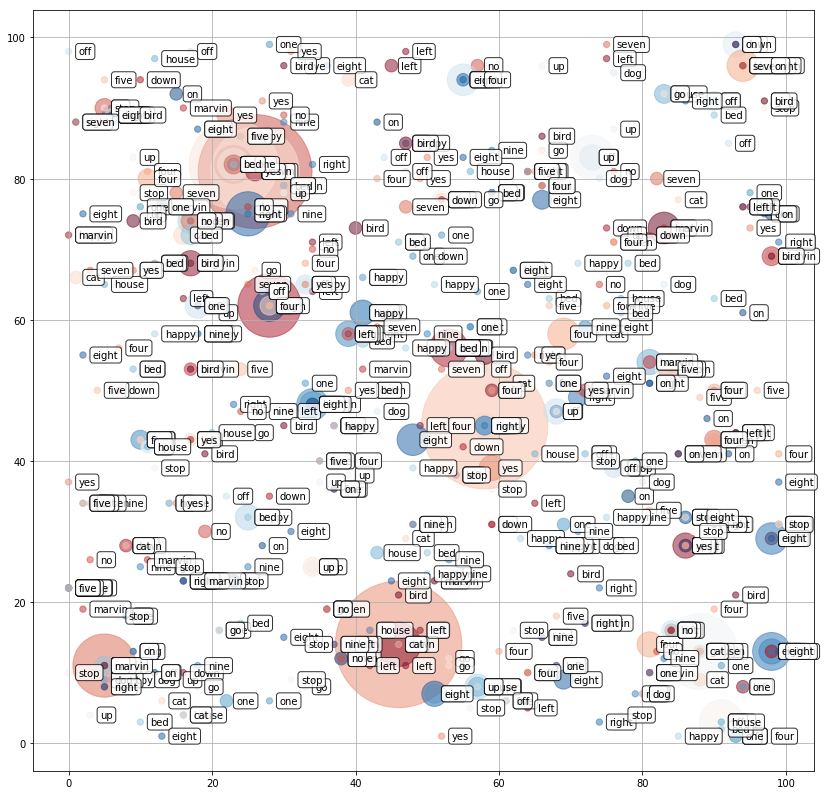

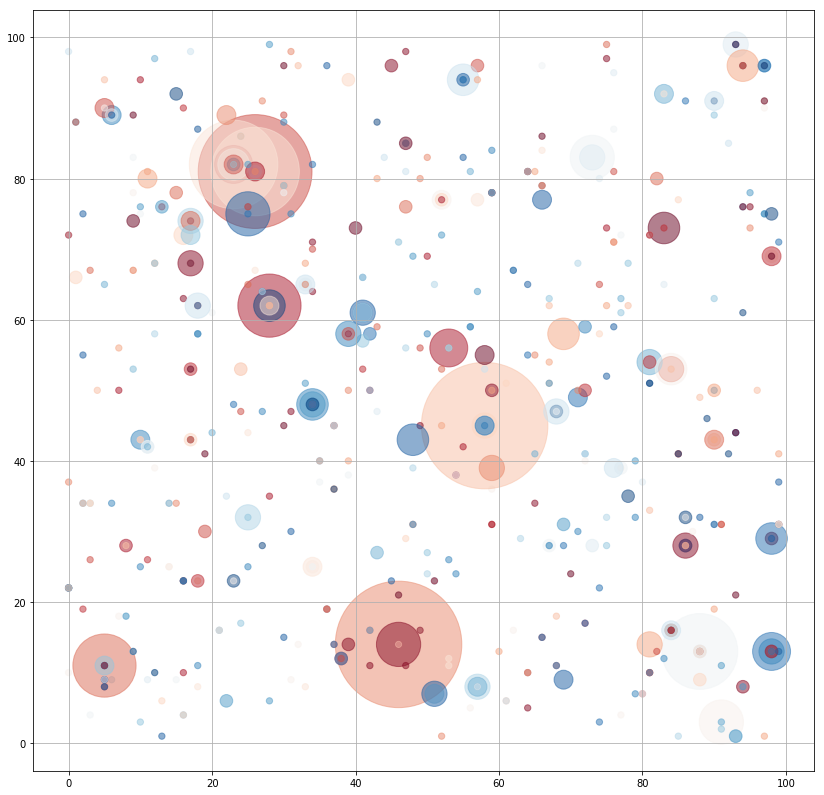

<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [8]:
with sess.as_default():
    bmus = som.get_bmus(test_x)
utils.view_bmus(bmus, test_y, default_marker_size=40, annotate=True)
utils.view_bmus(bmus, test_y, default_marker_size=40, annotate=False)

## 7 - Train SOM and save it

In [9]:
with sess.as_default():
    som.train(train_x, num_epochs=10, neighbour_sigma_start=40, neighbour_sigma_end=1,
              learning_rate_start=0.1, learning_rate_end=0.01, verbose=2)
    saver = tf.train.Saver()
    saver.save(sess, "./logs/"+name)


epoch: 1 out of 10
...processing 9900 out of 10000
epoch: 2 out of 10
...processing 9900 out of 10000
epoch: 3 out of 10
...processing 9900 out of 10000
epoch: 4 out of 10
...processing 9900 out of 10000
epoch: 5 out of 10
...processing 9900 out of 10000
epoch: 6 out of 10
...processing 9900 out of 10000
epoch: 7 out of 10
...processing 9900 out of 10000
epoch: 8 out of 10
...processing 9900 out of 10000
epoch: 9 out of 10
...processing 9900 out of 10000
epoch: 10 out of 10
...processing 9900 out of 10000
learning finished...


## 8 - Run trained SOM on test data and plot bmus

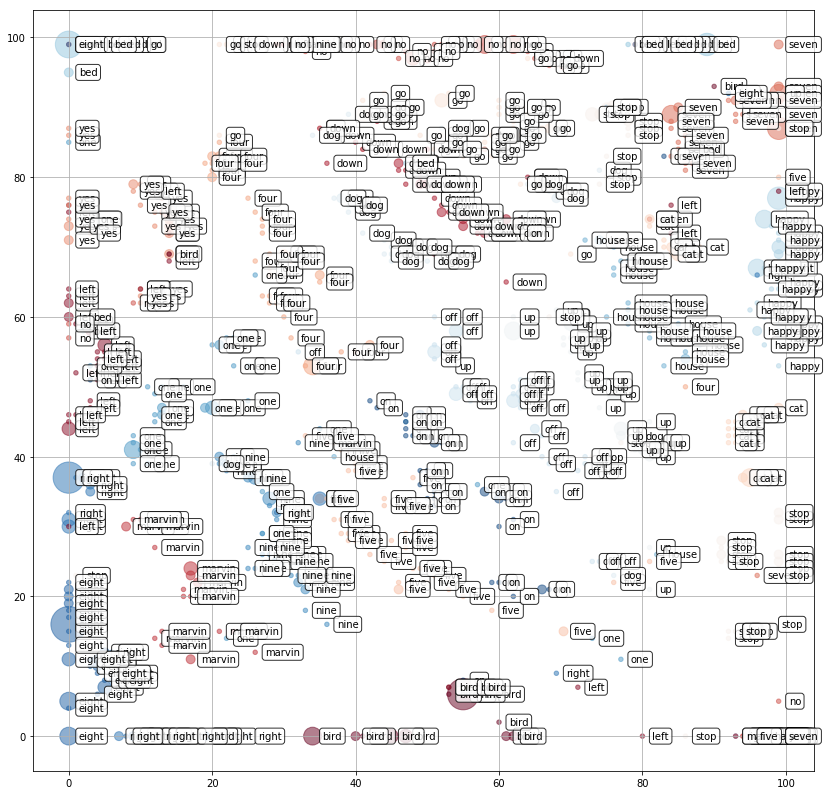

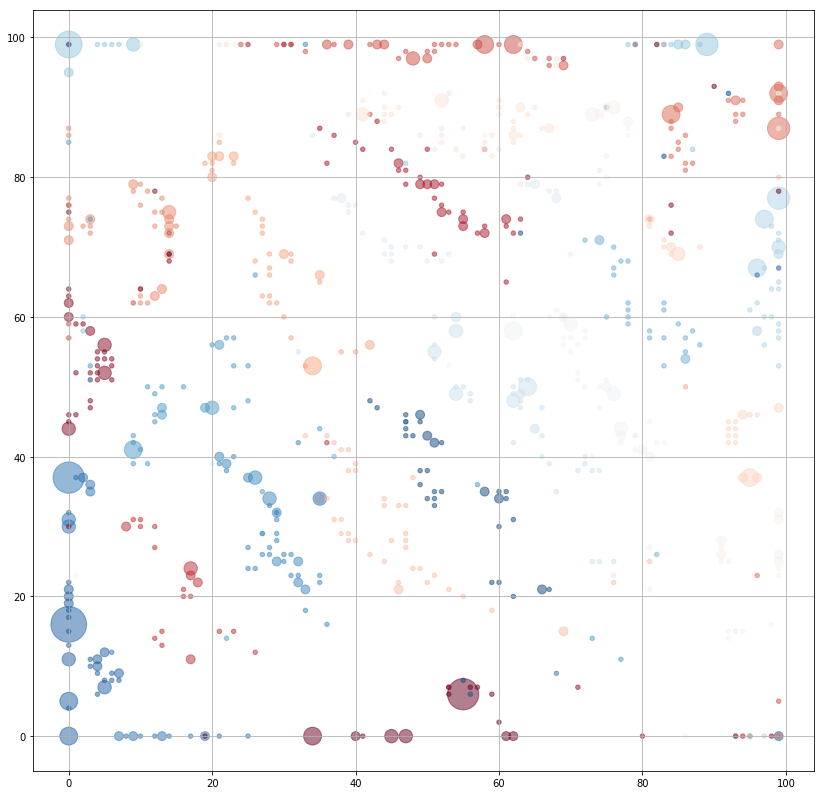

<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [10]:
with sess.as_default():
    bmus = som.get_bmus(test_x)
    
utils.view_bmus(bmus, test_y, annotate=True)
utils.view_bmus(bmus, test_y)


epoch: 1 out of 5
...processing 9900 out of 10000
epoch: 2 out of 5
...processing 9900 out of 10000
epoch: 3 out of 5
...processing 9900 out of 10000
epoch: 4 out of 5
...processing 9900 out of 10000
epoch: 5 out of 5
...processing 9900 out of 10000
learning finished...


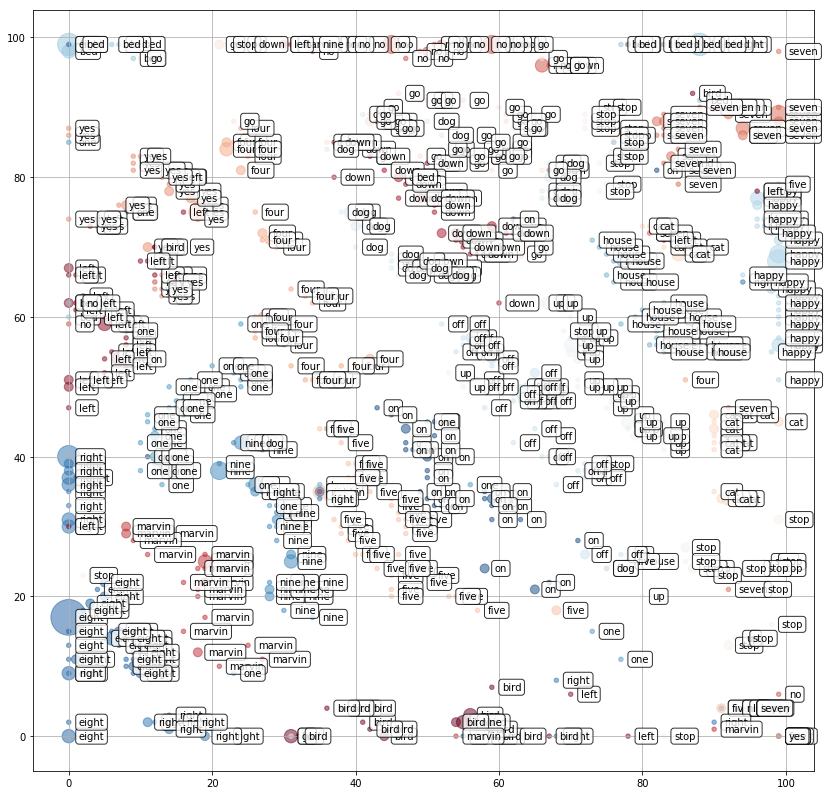

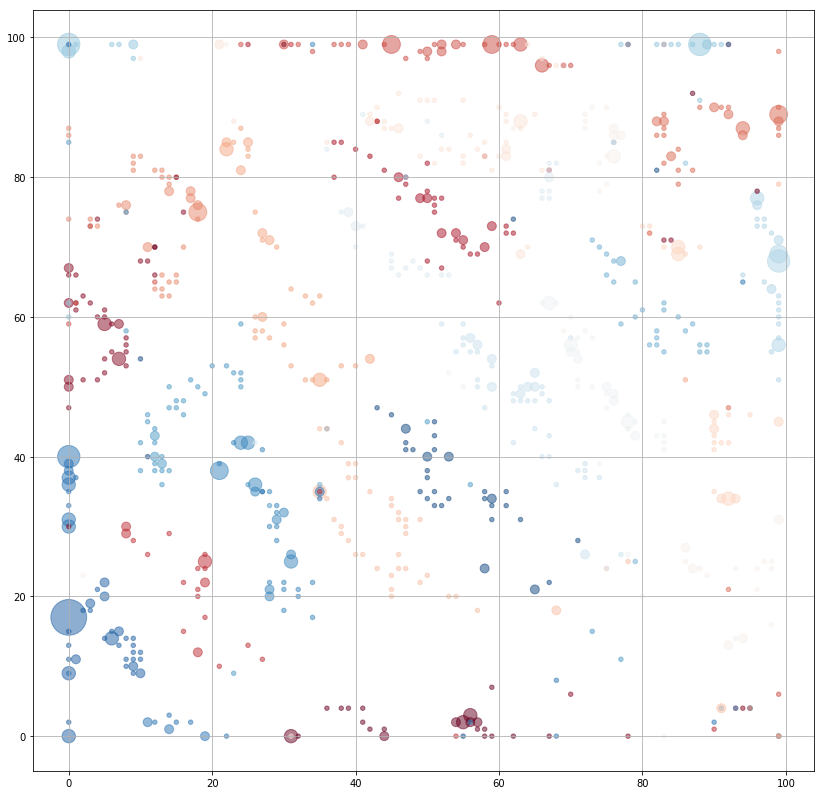

<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [11]:
with sess.as_default():
    som.train(train_x, num_epochs=5, neighbour_sigma_start=5, neighbour_sigma_end=1,
              learning_rate_start=0.05, learning_rate_end=0.01, verbose=2)
    saver = tf.train.Saver()
    saver.save(sess, "./logs/"+name+"10")
with sess.as_default():
    bmus = som.get_bmus(test_x)
    
utils.view_bmus(bmus, test_y, annotate=True)
utils.view_bmus(bmus, test_y)